In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from keras.regularizers import l2
import warnings
import pprint
%matplotlib inline
warnings.filterwarnings("ignore")

In [117]:
df = pd.read_csv(r"D:\DS\Datasets\Aep_hourly\AEP_hourly.csv")
print("="*50)
print("First Five Rows ","\n")
print(df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None 

Describe the Dataset  

              AEP_MW
count  121273.000000
mean    15499.513717
std      2591.399065
min      9581.000000
25%     13630.000000
50%     15310.000000
75%     17200.000000
max     25695.000000 

Null Values t  

Datetime    0
AEP_MW      0
dtype: int64 



In [118]:
# Extract all Data Like Year MOnth Day Time etc
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).apply(lambda x: x.timestamp())
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(1)

,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,1.104455e+09,53,31


In [119]:
# How many Unique Year do we Have in Dataset 
print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018] 

Total Number of Unique Year 15 



In [120]:
def find_outliers(dataset, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    condition = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers = df[condition]
    
    return outliers

In [121]:
AEP_outliers = find_outliers(dataset, 'AEP_MW')
AEP_outliers

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day
272,2004-12-20 09:00:00,22577.0,12,2004,2004-12-20,1.103533e+09,52,20
2478,2005-12-20 08:00:00,22573.0,12,2005,2005-12-20,1.135066e+09,51,20
5603,2005-08-12 14:00:00,22909.0,8,2005,2005-08-12,1.123855e+09,32,12
5604,2005-08-12 15:00:00,23371.0,8,2005,2005-08-12,1.123859e+09,32,12
5605,2005-08-12 16:00:00,23243.0,8,2005,2005-08-12,1.123862e+09,32,12
...,...,...,...,...,...,...,...,...
120848,2018-01-18 08:00:00,22567.0,1,2018,2018-01-18,1.516262e+09,3,18
121208,2018-01-03 08:00:00,22759.0,1,2018,2018-01-03,1.514966e+09,1,3
121209,2018-01-03 09:00:00,22624.0,1,2018,2018-01-03,1.514970e+09,1,3
121232,2018-01-02 08:00:00,22685.0,1,2018,2018-01-02,1.514880e+09,1,2


Boxplot to figureout outliers

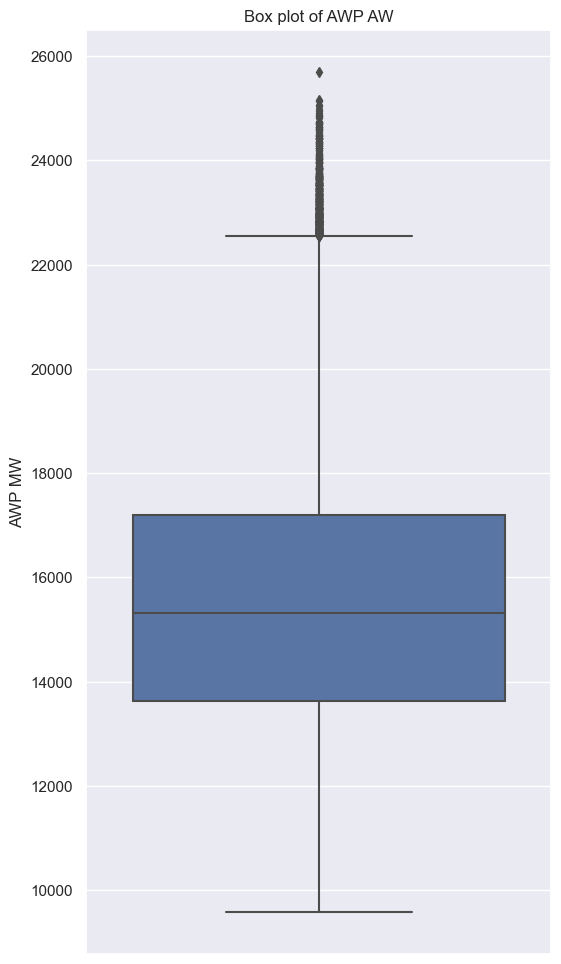

In [123]:
# Box plot of Average Daily Rate
plt.figure(figsize=(6, 12))
sns.boxplot(y=dataset['AEP_MW'])
plt.title('Box plot of AWP AW')
plt.ylabel('AWP MW')
plt.show()

In [124]:
def remove_outliers(dataset, col):
    q1 = dataset[col].quantile(0.25)
    q3 = dataset[col].quantile(0.75)

    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Condition for filtering out outliers
    condition = (dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)
    
    # Removing outliers
    cleaned_dataset = dataset[condition]

    return cleaned_dataset

In [125]:
cleaned_df = remove_outliers(df, 'AEP_MW')

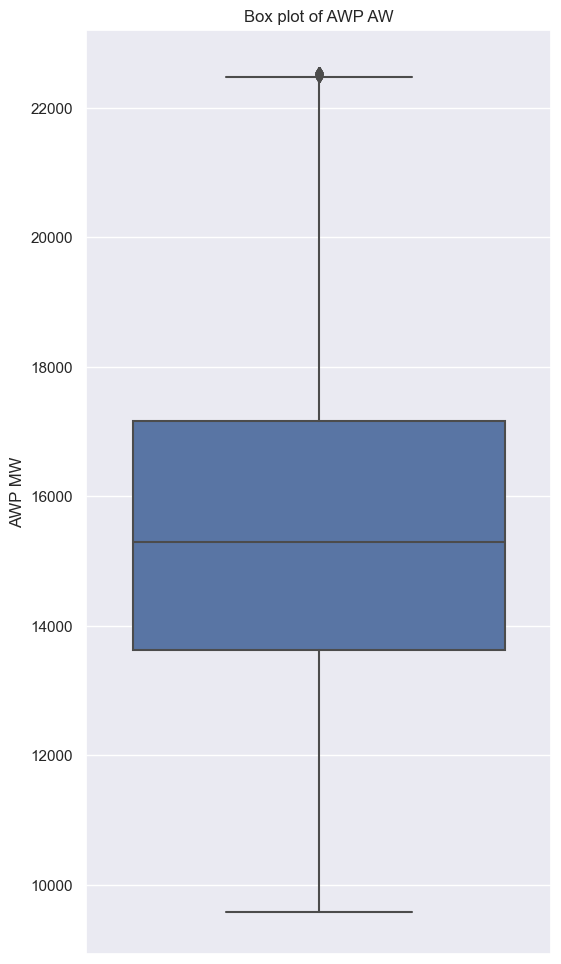

In [126]:
# Box plot of Average Daily Rate
plt.figure(figsize=(6, 12))
sns.boxplot(y=cleaned_df['AEP_MW'])
plt.title('Box plot of AWP AW')
plt.ylabel('AWP MW')
plt.show()

### Energy With Respect to Dates

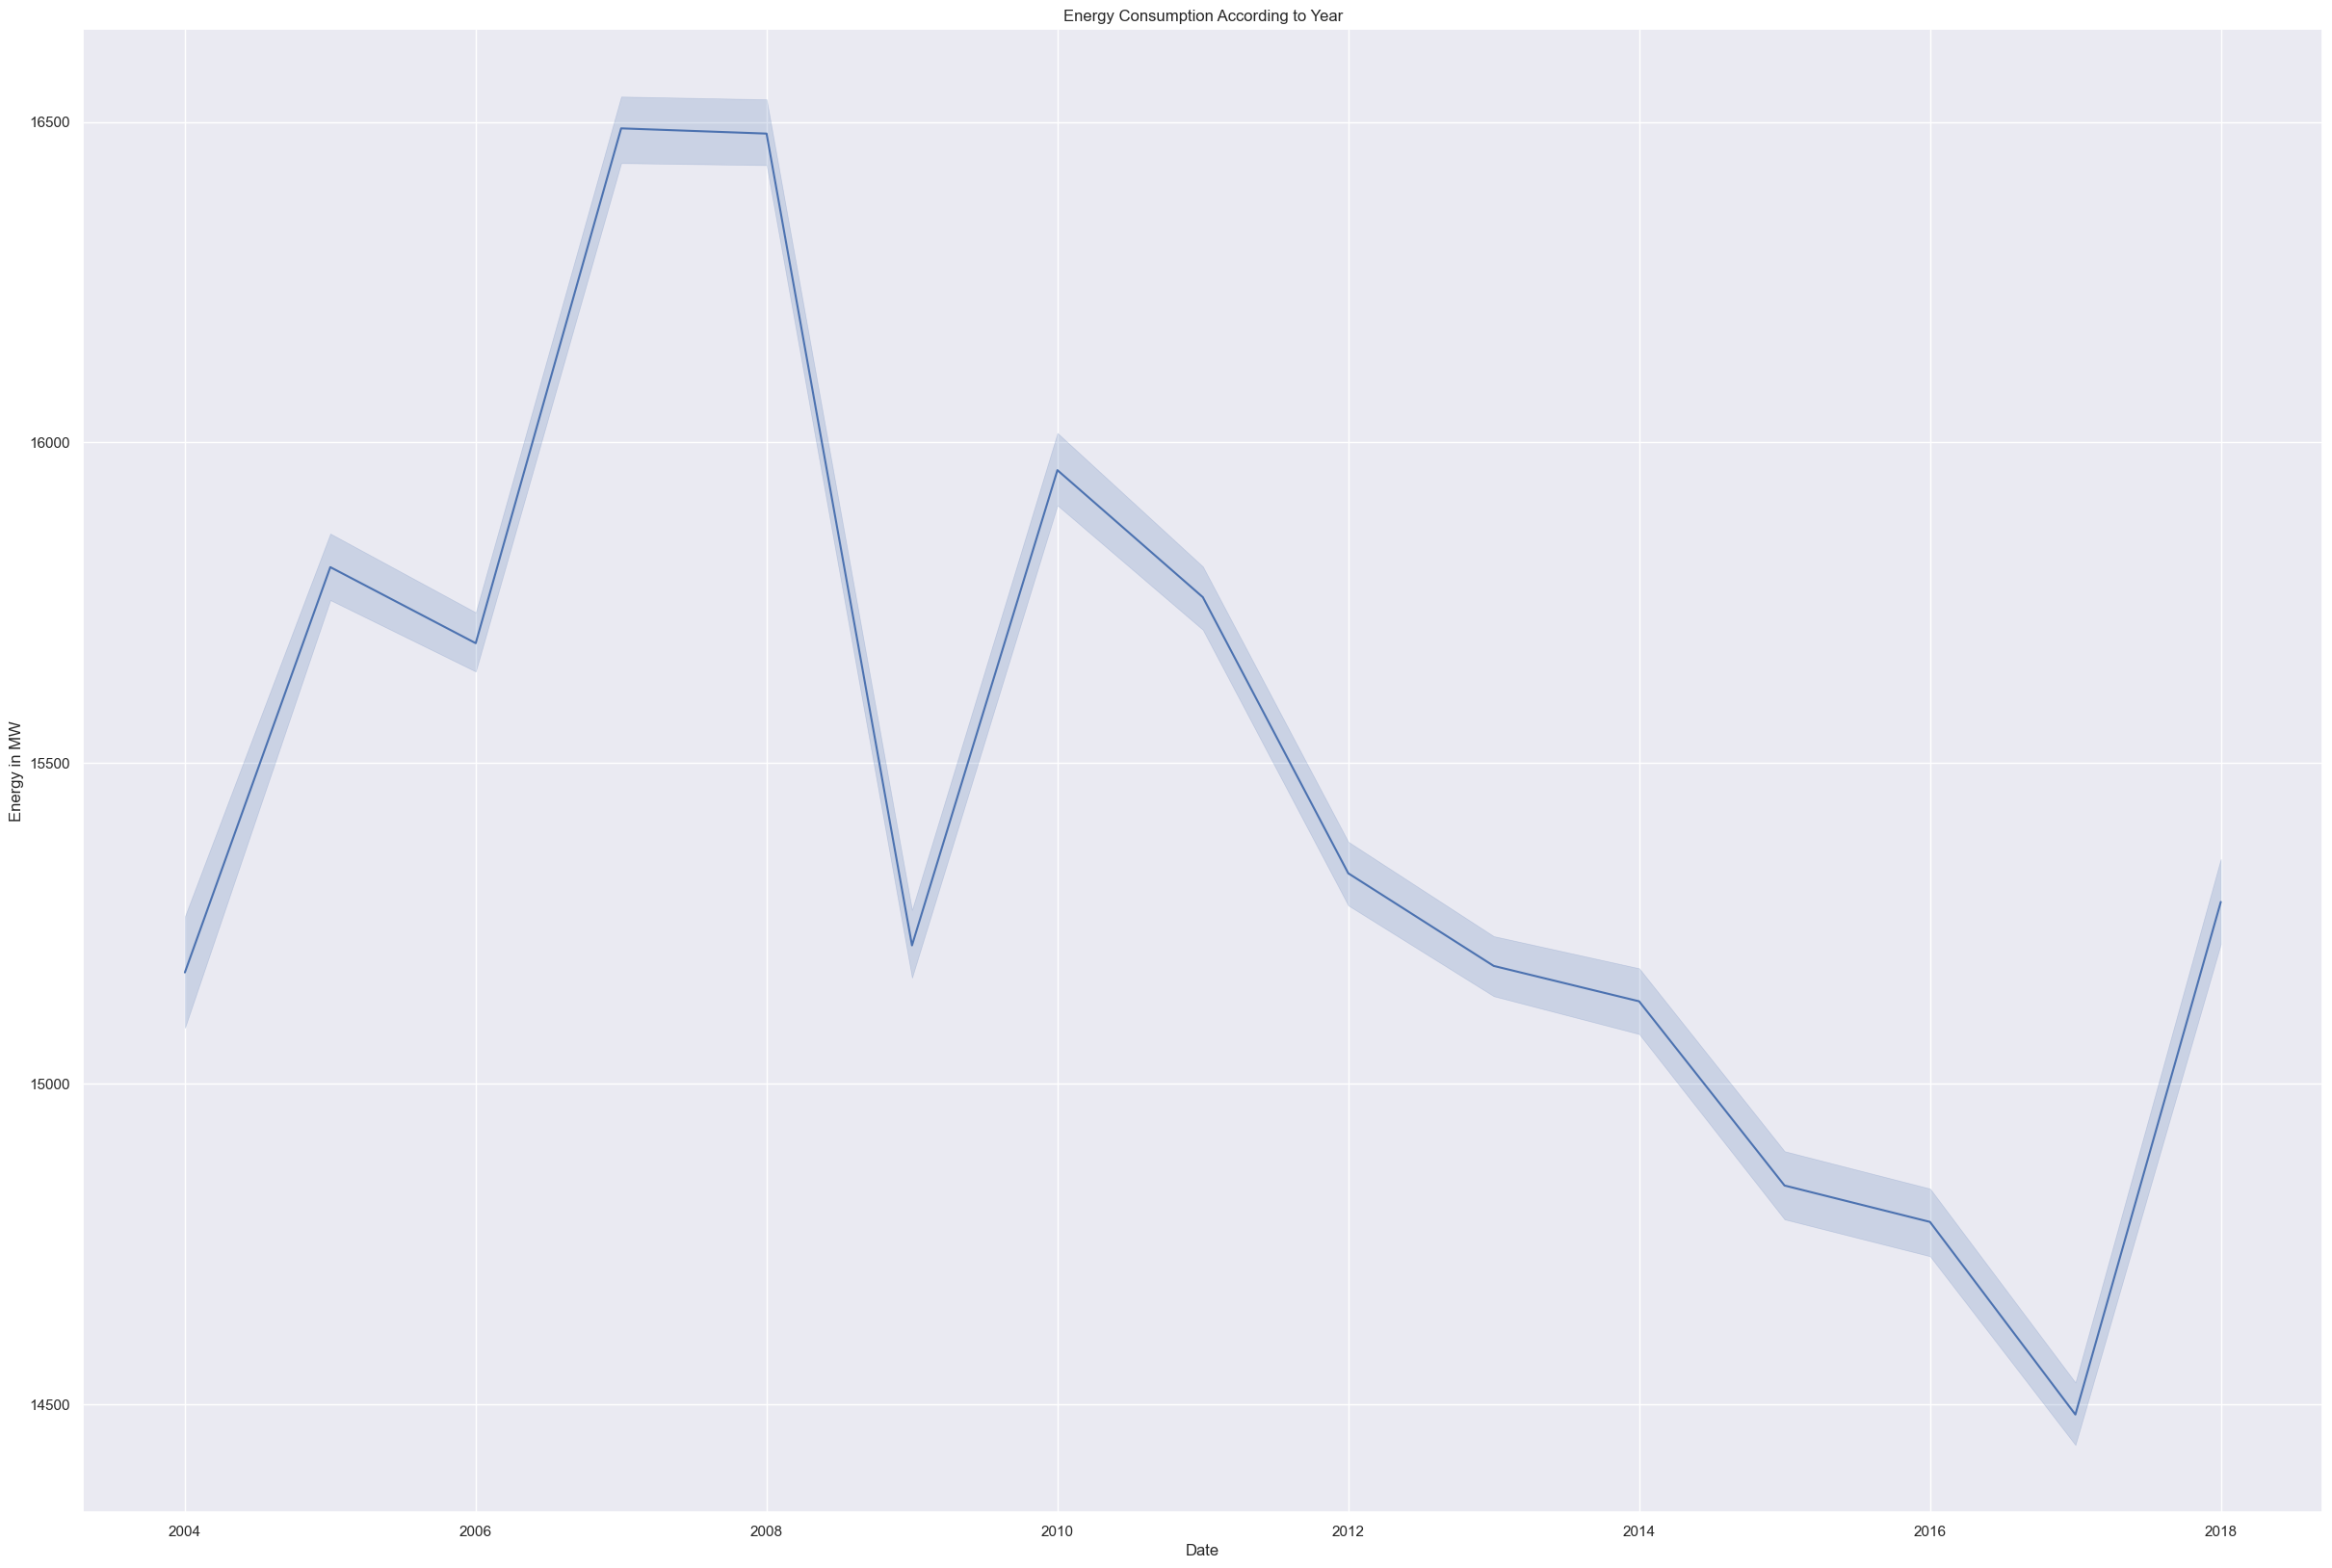

In [128]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1),(0,0))

style.use('ggplot')

sns.lineplot (x=cleaned_df["Year"], y=cleaned_df["AEP_MW"])
sns.set(rc = {'figure.figsize' :(15,6)})

# plt.title("Energy consumption in Year 2015")
plt.title("Energy Consumption According to Year")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.show()
# plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

# plot.title("Energy Consumption According to Year")

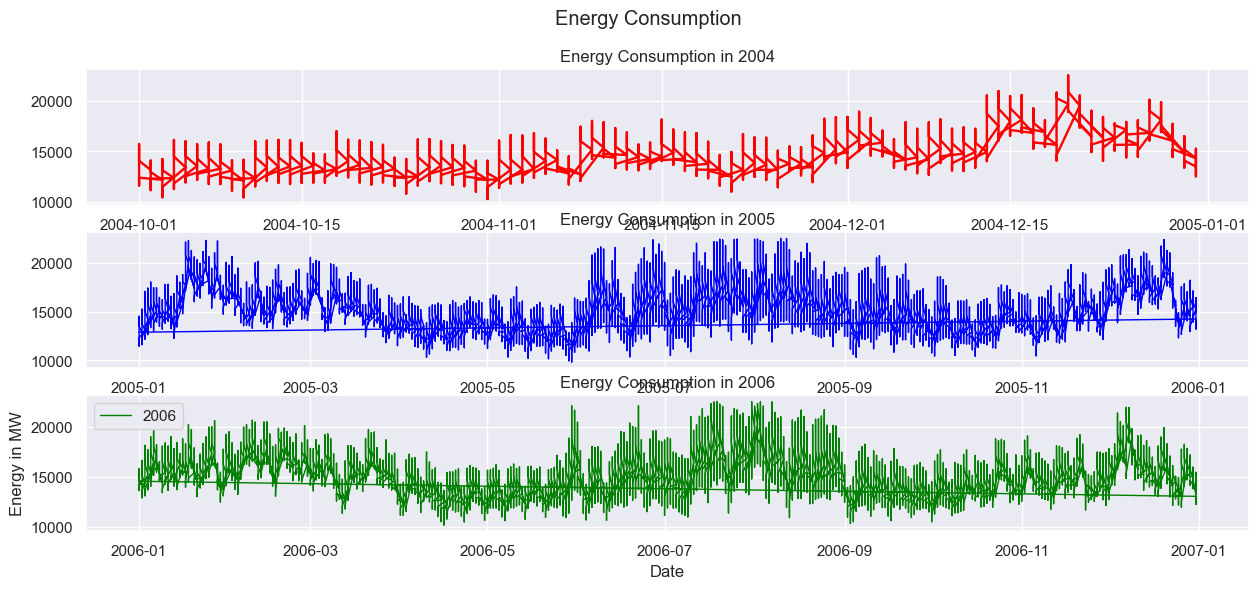

In [129]:
# Assuming 'dataset' is already defined and contains a 'Date' column
# Ensure 'Date' is in datetime format
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Set 'Date' as the index
cleaned_df.set_index('Date', inplace=True)

# Create the figure and subplots
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Optional: Use a specific style
# plt.style.use('ggplot')

# Plot for 2004
y_2004 = cleaned_df.loc['2004']['AEP_MW'].to_list()
x_2004 = cleaned_df.loc['2004'].index.to_list()  # Use index for x-axis
ax1.plot(x_2004, y_2004, color="red", linewidth=1.7, label="2004")

# Plot for 2005
y_2005 = cleaned_df.loc['2005']['AEP_MW'].to_list()
x_2005 = cleaned_df.loc['2005'].index.to_list()  # Use index for x-axis
ax2.plot(x_2005, y_2005, color="blue", linewidth=1, label="2005")

# Plot for 2006
y_2006 = cleaned_df.loc['2006']['AEP_MW'].to_list()
x_2006 = cleaned_df.loc['2006'].index.to_list()  # Use index for x-axis
ax3.plot(x_2006, y_2006, color="green", linewidth=1, label="2006")

# Set figure size
plt.rcParams["figure.figsize"] = (30, 20)  # Set a valid height

# Set titles and labels
plt.suptitle("Energy Consumption")
ax1.set_title("Energy Consumption in 2004")
ax2.set_title("Energy Consumption in 2005")
ax3.set_title("Energy Consumption in 2006")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()
plt.show()

### Energy Distribution

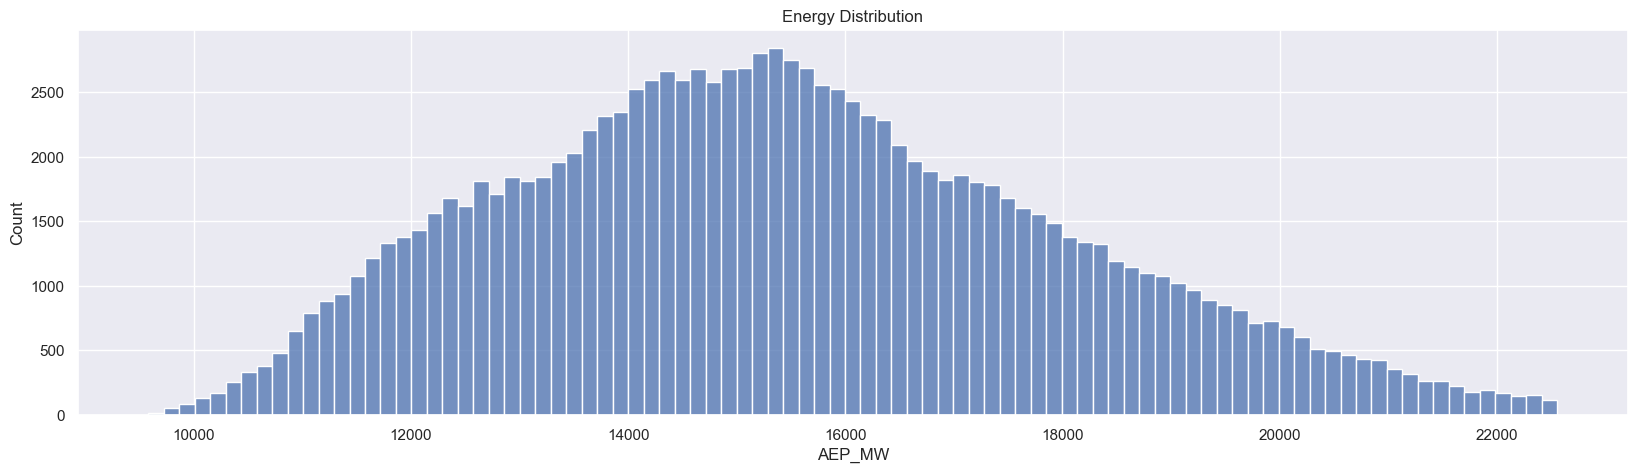

In [131]:
plt.figure(figsize = (20,5))

sns.histplot(cleaned_df["AEP_MW"])

plt.title("Energy Distribution")
plt.show()

### Energy with Respect to Time

KeyboardInterrupt: 

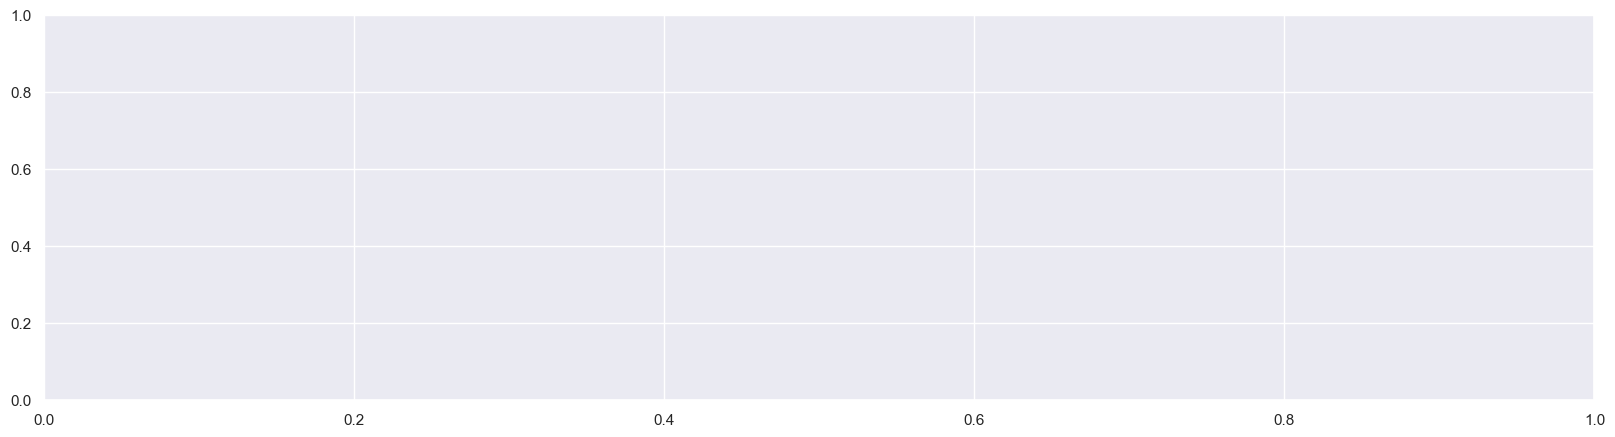

In [141]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x = dataset["Time"], y=dataset["AEP_MW"],data = dataset)
plt.title("Energy consumption vs Time")
plt.xlabel("Time")
plt.grid(True, alpha = 1)
plt.xticks(rotation=90)

In [143]:
dataset.dtypes

AEP_MW    float64
Month       int32
Year        int32
Date       object
Time      float64
Week       UInt32
Day         int32
dtype: object

In [145]:
NewDataSet = dataset.select_dtypes(include=[np.number]).resample('D').mean()

In [147]:
print("Old Dataset ",dataset.shape )
print("New  Dataset ",NewDataSet.shape )

Old Dataset  (121273, 7)
New  Dataset  (5055, 6)


In [149]:
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet.iloc[:,0:1]

Training_Set = Training_Set[:-60]

In [151]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (4995, 1)
Test Set Shape  (100, 6)


In [153]:
Training_Set = Training_Set.values
sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [155]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(4935, 60, 1)
(4935, 1)


In [157]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(4935, 60, 1)

In [159]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [161]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 0.0324
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0189
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0188
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 0.0160
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 0.0160
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0149
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - loss: 0.0154
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0136
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 0.0109
Epoch 10/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 0.0099
Epoch 11/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0088
Epoch 12/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0085
Epoch 13/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 0.0081
Epoch 14/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0074
Epoch 15/50
155/155 ━━━━━━━━━

In [162]:
TestData.head(2)

,AEP_MW,Month,Year,Time,Week,Day
Datetime,,,,,,
2018-04-26,13157.791667,4.0,2018.0,1.524742e+09,17.0,26.0
2018-04-27,12964.000000,4.0,2018.0,1.524829e+09,17.0,27.0


In [163]:
TestData.shape

(100, 6)

In [164]:
NewDataSet.shape

(5055, 6)

In [165]:
Df_Total = pd.concat((NewDataSet[["AEP_MW"]], TestData[["AEP_MW"]]), axis=0)

In [166]:
Df_Total.shape

(5155, 1)

In [167]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [168]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# We need to Reshape
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_stock_price = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step


In [169]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = predicted_stock_price
dates = TestData.index.to_list()

In [170]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueMegaWatt": True_MegaWatt,
    "PredictedMeagWatt":[x[0] for x in Predicted_MegaWatt ]
})

In [171]:
Machine_Df

,Date,TrueMegaWatt,PredictedMeagWatt
0,2018-04-26,13157.791667,13970.935547
1,2018-04-27,12964.000000,13074.847656
2,2018-04-28,12237.583333,14816.315430
3,2018-04-29,12156.791667,13813.758789
4,2018-04-30,13443.500000,13348.368164
...,...,...,...
95,2018-07-30,15368.083333,15365.753906
96,2018-07-31,15180.291667,16001.528320
97,2018-08-01,15151.166667,15575.836914
98,2018-08-02,15687.666667,15601.813477


In [172]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = [x[0] for x in Predicted_MegaWatt ]
dates = TestData.index.to_list()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


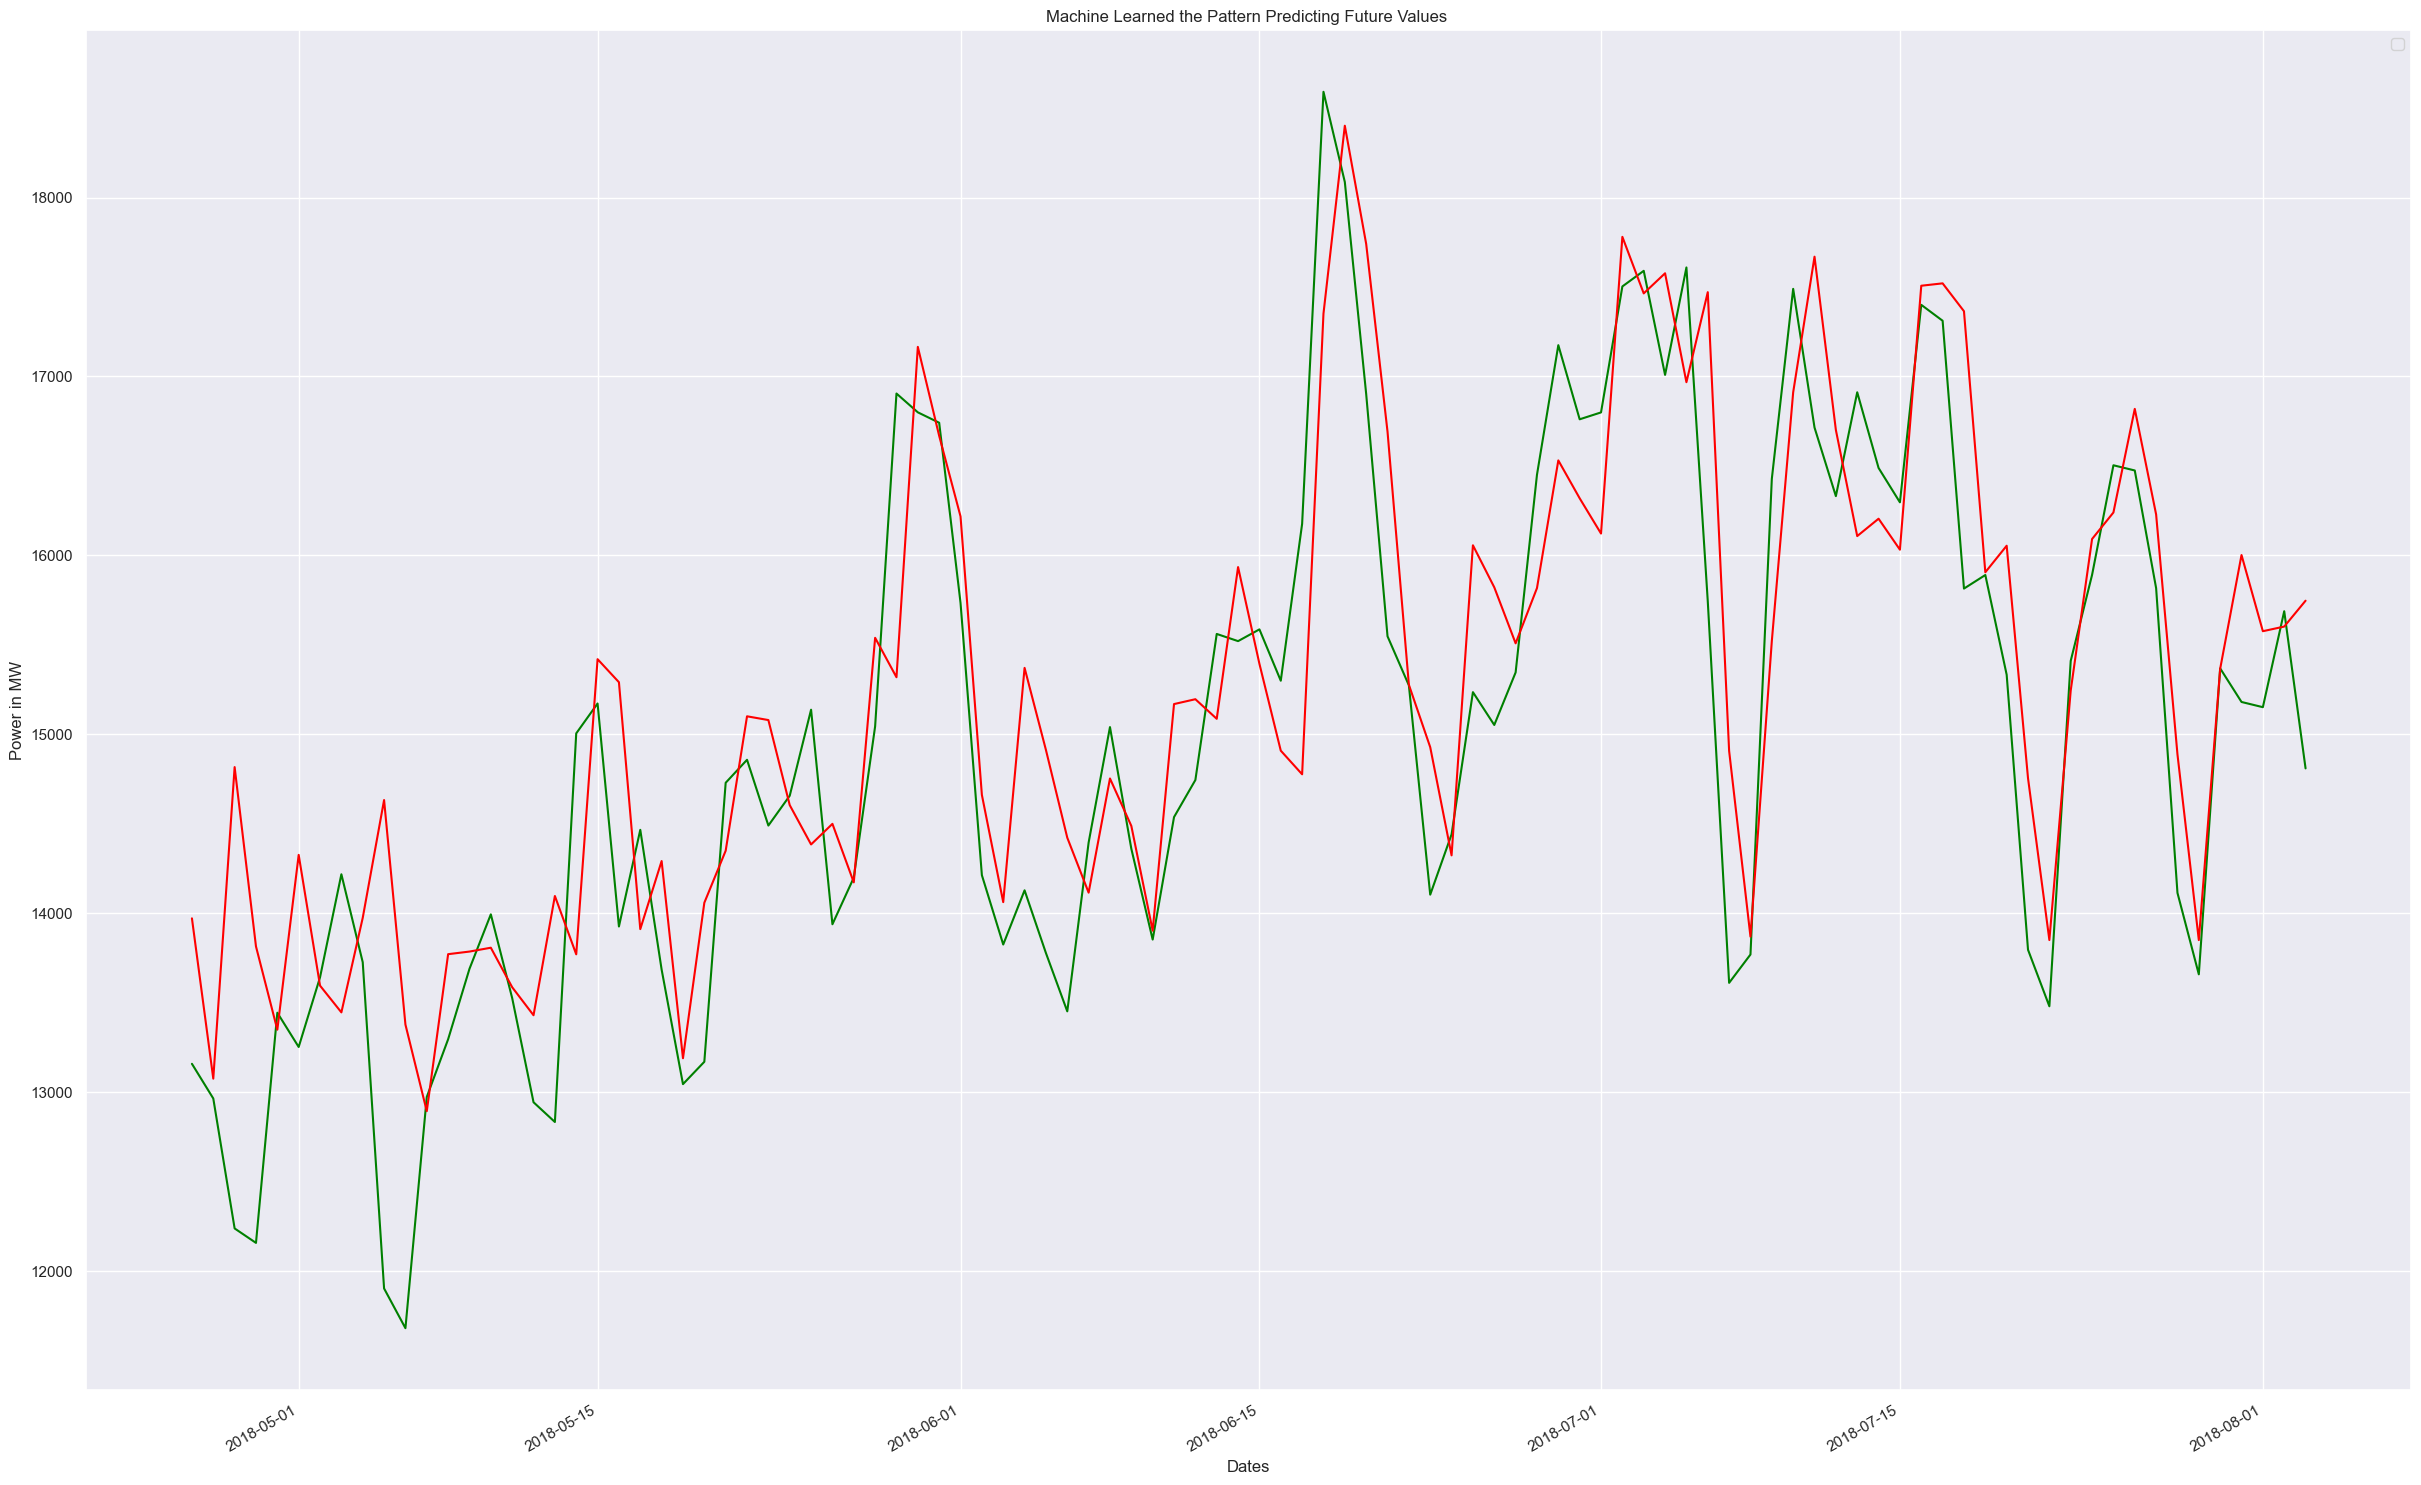

In [173]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_MegaWatt

y1 = Predicted_MegaWatt

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()

In [174]:
import pickle

# Save the model to a file
with open('PredictionModel.pkl', 'wb') as file:
    pickle.dump(regressor, file)